# Monte Carlo Dispersion Analysis with the Dispersion Class


Finally the Monte Carlo simulations can be performed using a dedicated class called Dispersion.
Say goodbye to the long and tedious process of creating the Monte Carlo Simulations throughout jupyter notebooks!


In [1]:
%load_ext autoreload
%autoreload 2

First, let's import the necessary libraries, including the newest Dispersion class!


In [2]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Dispersion
from rocketpy.monte_carlo import (
    McEnvironment,
    McSolidMotor,
    McRocket,
    McFlight,
    McNoseCone,
    McTail,
    McTrapezoidalFins,
    McParachute,
)
import datetime


If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.


In [3]:
%matplotlib inline

The Dispersion class allows us to perform Monte Carlo Simulations in a very simple way.
We just need to create an instance of the class, and then call the method `run_dispersion()` to perform the simulations.
The class has a lot of capabilities, but we will only use a few of them in this example.
We encourage you to check the documentation of the class to learn more about the Dispersion.

Also, you can check RocketPy's main reference for a better conceptual understanding
of the Monte Carlo Simulations: [RocketPy: Six Degree-of-Freedom Rocket Trajectory Simulator](<https://doi.org/10.1061/(ASCE)AS.1943-5525.0001331>)

TODO: improve the description


## First Step: Creating the Inputs for the Simulations


### Environment


In [5]:
env = Environment(
    railLength=5.7, latitude=39.389700, longitude=-8.288964, elevation=113
)

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 12))  # Hour given in UTC time

env.setAtmosphericModel(type="Ensemble", file="GEFS")


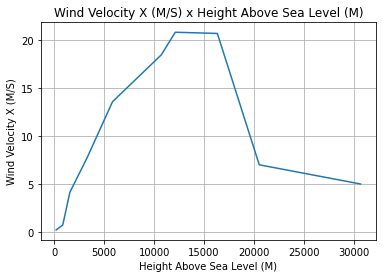

In [26]:
env.windVelocityX()

TODO: Improve docs
Here we only add a standard deviation to rail length of 0.005


In [29]:
mc_env = McEnvironment(
    environment=env,
    railLength='0.005',
    ensembleMember = [0,1,2,20]
)

mc_env

# TODO: improve the print or __repr__() of these Monte Carlo classes


first?


ValidationError: 1 validation error for McEnvironment
__root__
  
Field 'railLength' 
	Must be either a tuple, list, int or float (type=value_error)

### Motor


Let's define the motor using the firs method. We will be using the data from the manufacturer, and following
the [RocketPy's documentation](https://docs.rocketpy.org/en/latest/user/index.html).


In [6]:
motor = SolidMotor(
    thrustSource="../../../data/motors/Cesaroni_M1670.eng",
    burnOutTime=3.9,
    grainsCenterOfMassPosition=-0.85704,
    grainNumber=5,
    grainSeparation=5 / 1000,
    grainDensity=1815,
    grainOuterRadius=33 / 1000,
    grainInitialInnerRadius=15 / 1000,
    grainInitialHeight=120 / 1000,
    nozzleRadius=33 / 1000,
    throatRadius=11 / 1000,
    interpolationMethod="linear",
    nozzlePosition=-1.255,
    coordinateSystemOrientation="nozzleToCombustionChamber",
)


In [7]:
mc_motor = McSolidMotor(
    solidMotor=motor,
    burnOutTime=1,
    grainsCenterOfMassPosition=0.001,
    grainDensity=50,
    grainInitialHeight=0.001,
    totalImpulse=100,
    throatRadius=0.0005,
    nozzlePosition=0.001,
)
mc_motor

McSolidMotor(thrustSource=['../../../data/motors/Cesaroni_M1670.eng'], burnOutTime=(3.9, 1), grainsCenterOfMassPosition=(-0.85704, 0.001), grainNumber=[5], grainDensity=(1815, 50), grainOuterRadius=(0.033, 0), grainInitialInnerRadius=(0.015, 0), grainInitialHeight=(0.12, 0.001), grainSeparation=(0.005, 0), totalImpulse=(6026.35, 100), nozzleRadius=(0.033, 0), nozzlePosition=(-1.255, 0.001), throatRadius=(0.011, 0.0005))

### Rocket


In [8]:
rocket = Rocket(
    radius=127 / 2000,
    mass=19.197 - 2.956,
    inertiaI=6.60,
    inertiaZ=0.0351,
    powerOffDrag="../../../data/calisto/powerOffDragCurve.csv",
    powerOnDrag="../../../data/calisto/powerOnDragCurve.csv",
    centerOfDryMassPosition=0,
    coordinateSystemOrientation="tailToNose",
)

rocket.setRailButtons([0.2, -0.5])

rocket.addMotor(motor, position=-1.255)

nose_cone = rocket.addNose(length=0.55829, kind="vonKarman", position=1.278)

fin_set = rocket.addTrapezoidalFins(
    n=4,
    rootChord=0.120,
    tipChord=0.040,
    span=0.100,
    position=-1.04956,
)

tail = rocket.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, position=-1.194656
)


Additionally, we set parachutes for our Rocket, as well as the trigger functions for the deployment of such parachutes.


In [9]:
def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 500 + 100 m (+100 due to surface elevation).
    return True if y[5] < 0 and y[2] < 500 + 100 else False


main_chute = rocket.addParachute(
    "Main",
    CdS=10.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

drogue_chute = rocket.addParachute(
    "Drogue",
    CdS=1.0,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)


In [10]:
mc_rocket = McRocket(
    rocket=rocket,
    radius=1,
    mass=1,
    inertiaZ=1,
    powerOffDragFactor=(1, 0.03),
    powerOnDragFactor=(1, 0.03),
)
mc_rocket

McRocket(radius=(0.0635, 1), mass=(16.241, 1), inertiaI=(6.6, 0), inertiaZ=(0.0351, 1), powerOffDrag=[Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power Off)], powerOnDrag=[Function from R1 to R1 : (Mach Number) → (Drag Coefficient with Power On)], centerOfDryMassPosition=(0, 0), powerOffDragFactor=(1, 0.03), powerOnDragFactor=(1, 0.03))

In [11]:
mc_nose_cone = McNoseCone(
    nosecone=nose_cone,
    length=0.001,
)

mc_fin_set = McTrapezoidalFins(
    trapezoidalFins=fin_set,
    rootChord=0.001,
    tipChord=0.001,
    span=0.001,
)

mc_tail = McTail(
    tail=tail,
    topRadius=0.001,
    bottomRadius=0.001,
    length=0.001,
)

mc_main = McParachute(
    parachute=main_chute,
    CdS=0.1,
    lag=0.1,
)

mc_drogue = McParachute(
    parachute=drogue_chute,
    CdS=0.1,
    lag=0.1,
)


In [12]:
mc_rocket.addMotor(mc_motor,position=0.001)
mc_rocket.addNose(mc_nose_cone,position=(1.278,0.001))
mc_rocket.addTrapezoidalFins(mc_fin_set,position=(0.001,"dist_func"))
mc_rocket.addTail(mc_tail,position=(-1.194656,0.001,"dist_func"))
mc_rocket.addParachute(mc_main)
mc_rocket.addParachute(mc_drogue)


In [13]:
print(mc_rocket.motors[0].position)
print(mc_rocket.nosecones[0].position)
print(mc_rocket.fins[0].position)
print(mc_rocket.tails[0].position)


(-1.255, 0.001)
(1.278, 0.001)
(-1.04956, 0.001, 'dist_func')
(-1.194656, 0.001, 'dist_func')


### Flight


In [14]:
test_flight = Flight(
    rocket=rocket,
    environment=env,
    inclination=84,
    heading=133,
)


In [15]:
mc_flight = McFlight(
    flight=test_flight,
    inclination=(84, 1),
    heading=(133, 1),
)


And we can visualize the flight trajectory:


In [ ]:
# test_flight.plots.trajectory_3d()


### Starting the Monte Carlo Simulations


First, let's invoke the Dispersion class, we only need a filename to initialize it.
The filename will be used either to save the results of the simulations or to load them
from a previous ran simulation.


In [ ]:
test_dispersion = Dispersion(
    filename="dispersion_analysis_outputs/disp_class_example",
    environment=mc_env,
    rocket=mc_rocket,
    flight=mc_flight,
)

# TODO: add custom warning o when the rocket doesn't have a motors, parachute, or aerosurfaces


Then, we can run the simulations using the method Dispersion.run_dispersion().
But before that, we need to set some simple parameters for the simulations.
We will set them by using a dictionary, which is one of the simplest way to do it.


Finally, let's iterate over the simulations and export the data from each flight simulation!


In [ ]:
test_dispersion.run_dispersion(
    number_of_simulations=50,
    append=False,
)

# TODO: it seems the dispersion is falling into an eternal loop. Need to check it out 


In [ ]:
# In case you want to verify the new dispersion dictionary format...
test_dispersion.dispersion_dictionary


### Visualizing the results


Now we finally have the results of our Monte Carlo simulations loaded!
Let's play with them.


First, we can print numerical information regarding the results of the simulations.


In [ ]:
test_dispersion.import_results()


In [ ]:
test_dispersion.print_results()


Also, we can visualize histograms of such results


In [ ]:
test_dispersion.allInfo()


Export to kml so it can be visualized in Google Earth


In [ ]:
test_dispersion.exportEllipsesToKML(
    filename="dispersion_analysis_outputs/disp_class_example.kml",
    origin_lat=env.latitude,
    origin_lon=env.longitude,
    type="impact",
)
